# Lab 9 Task 2 - GoogleNet, Visualize 1x1 Convolution

### SAHIL AMRITKAR
### 20BRS1180  


In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

##### GooglNet Implementation

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [3]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-01 19:18:48.892995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-01 19:18:48.893174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


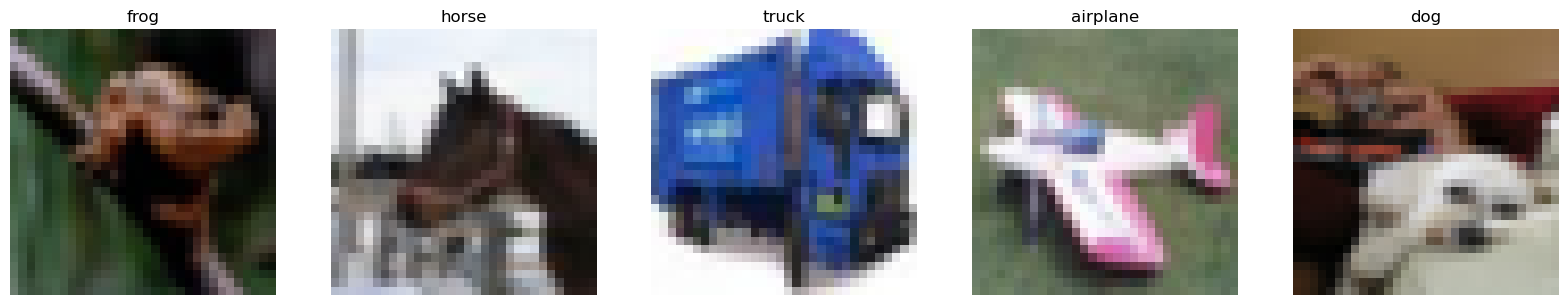

In [6]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [7]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (224,224))
    return image, label

In [8]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [9]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

In [11]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [12]:

def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1000, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [28]:
model=GoogLeNet()
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.RMSprop(), metrics=['accuracy'])
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 109, 109, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_59[0][0]']              
 )                                                                                        

In [14]:
history=model.fit(train_ds,
          epochs=1,
          validation_data=validation_ds,)

2023-03-01 19:18:53.083974: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-01 19:18:53.084676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-01 19:19:03.843178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 35291 of 45000
2023-03-01 19:19:07.137132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


1406/1406 [==============================] - ETA: 0s - loss: 9334856956780472172544.0000 - dense_4_loss: 12559539240960.0000 - dense_1_loss: 9334856956780472172544.0000 - dense_3_loss: 10292833550336.0000 - dense_4_accuracy: 0.0995 - dense_1_accuracy: 0.1036 - dense_3_accuracy: 0.1008

2023-03-01 19:25:18.640958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1406/1406 [==============================] - 400s 266ms/step - loss: 9334856956780472172544.0000 - dense_4_loss: 12559539240960.0000 - dense_1_loss: 9334856956780472172544.0000 - dense_3_loss: 10292833550336.0000 - dense_4_accuracy: 0.0995 - dense_1_accuracy: 0.1036 - dense_3_accuracy: 0.1008 - val_loss: 37690294266891069292544.0000 - val_dense_4_loss: 14085122.0000 - val_dense_1_loss: 37690294266891069292544.0000 - val_dense_3_loss: 12261115.0000 - val_dense_4_accuracy: 0.0974 - val_dense_1_accuracy: 0.1036 - val_dense_3_accuracy: 0.0974


In [29]:
print(len(model.layers))

95


##### Visualizing 1x1

In [30]:
from IPython.display import Image
Image(url="bird.jpeg", width=400, height=300)

In [20]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('bird.jpeg', target_size=(224, 224))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_59 (Conv2D)          (None, 109, 109, 64)      9472      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
Total params: 9,472
Trainable params: 9,472
Non-trainable params: 0
_________________________________________________________________


2023-03-01 19:29:56.269417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


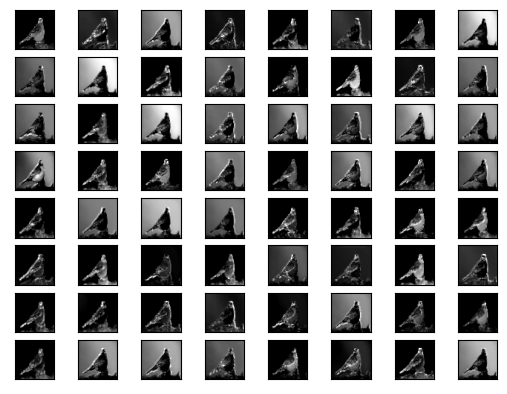

In [33]:
# BEFORE 1x1

# plot feature map of first conv layer for given image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# redefine model to output right after the first hidden layer
model_1 = Model(inputs=model.inputs, outputs=model.layers[2].output)
model_1.summary()
# load the image with the required shape
img = load_img('bird.jpeg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model_1.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_59 (Conv2D)          (None, 109, 109, 64)      9472      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 54, 54, 64)        4160      
                                                                 
Total params: 13,632
Trainable params: 13,632
Non-trainable params: 0
_________________________________________________________________


2023-03-01 19:30:00.759883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


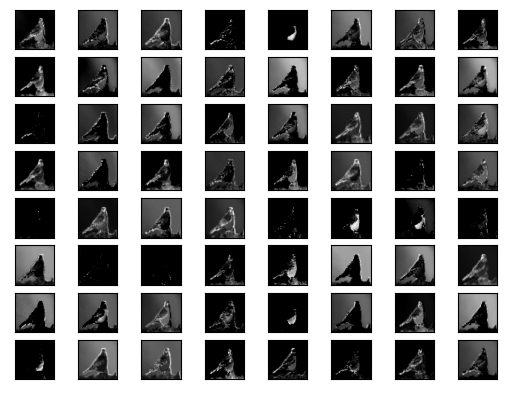

In [34]:
# AFTER 1x1

# plot feature map of first conv layer for given image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# redefine model to output right after the first hidden layer
model_2 = Model(inputs=model.inputs, outputs=model.layers[3].output)
model_2.summary()
# load the image with the required shape
img = load_img('bird.jpeg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model_2.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()